# Comparison between ClimateTRACE and C40 inventories

This analysis compares city aggregated estimates from [climateTRACE](https://climatetrace.org/) to estimates [GPC](https://ghgprotocol.org/ghg-protocol-cities) compliant C40 city inventories downloaded from [here](https://www.c40knowledgehub.org/s/article/C40-cities-greenhouse-gas-emissions-interactive-dashboard?language=en_US).

I am not sure if the C40 inventories are high quality. Comparing to downscaled observations would not be a fair comparison. 

In [1]:
import json
import os
import fnmatch
import pandas as pd
import tarfile
import os
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

In [2]:
from utils import (
    get_c40_data, 
    filter_out_notation_keys,
    climatetrace_file_names,
    load_climatetrace_file
)

/Users/sherrywang/dev/ClimateTRACE_C40/env/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Read raw C40 data

**Units**: metric tonnes CO2-eq. (I am assuming these are units since they should be following the GPC)

In [3]:
df_c40_raw = get_c40_data()

### filter C40

In [4]:
refnos = ['II.1.1']
columns = ['city', 'locode', 'year'] + refnos

df_tmp = filter_out_notation_keys(df_c40_raw, refnos)
df_c40 = (
    df_tmp
    .loc[:, columns]
    .rename(columns = {'II.1.1': 'emissions_c40'})
)

### Read ClimateTRACE

**Units**: Units are tonnes 

In [5]:
asset_file = './transportation/asset_road-transportation_emissions.csv'
df_ct_raw = load_climatetrace_file(asset_file)
filt = (df_ct_raw['gas'] == 'co2e_100yr')
df_data = df_ct_raw.loc[filt]

df_ct = (
    df_data
    .assign(year = lambda row: pd.to_datetime(row['start_time']).dt.year)
    .loc[:, ['asset_name', 'year', 'emissions_quantity', 'emissions_factor_units']]
    .rename(columns = {'emissions_quantity': 'emissions_ct', 'asset_name': 'city'})
)

## Comparison

In [6]:
df_int = pd.merge(df_ct, df_c40, on = ['year', 'city'], how='inner').sort_values('emissions_ct')
df_int['diff'] = df_int['emissions_ct'] - df_int['emissions_c40']
df_int['percent_error'] = (df_int['diff'] / df_int['emissions_c40']) * 100

In [7]:
df_int

,city,year,emissions_ct,emissions_factor_units,locode,emissions_c40,diff,percent_error
11,Stockholm,2021,7.912193e+05,average_tonnes_gas_per_vehicle_km_traveled,SE STO,510676,2.805433e+05,54.935682
10,Quito,2021,1.413371e+06,average_tonnes_gas_per_vehicle_km_traveled,EC UIO,2697180,-1.283809e+06,-47.598198
4,Milan,2021,1.898418e+06,average_tonnes_gas_per_vehicle_km_traveled,AU MEL,644852,1.253566e+06,194.395988
12,Auckland,2021,2.026304e+06,average_tonnes_gas_per_vehicle_km_traveled,NZ AKL,4018564,-1.992260e+06,-49.576426
7,Barcelona,2021,2.178303e+06,average_tonnes_gas_per_vehicle_km_traveled,ES BCN,840973,1.337330e+06,159.021703
1,Addis Ababa,2021,2.206382e+06,average_tonnes_gas_per_vehicle_km_traveled,ET ADD,3408787,-1.202405e+06,-35.273700
9,Vancouver,2021,2.788798e+06,average_tonnes_gas_per_vehicle_km_traveled,CA VAN,1003435,1.785363e+06,177.925103
5,Rio de Janeiro,2021,3.929899e+06,average_tonnes_gas_per_vehicle_km_traveled,BR RIO,3757135,1.727642e+05,4.598295
8,London,2021,4.471718e+06,average_tonnes_gas_per_vehicle_km_traveled,GB LDY,5671218,-1.199500e+06,-21.150655
6,Paris,2021,4.906189e+06,average_tonnes_gas_per_vehicle_km_traveled,FR PAR,861718,4.044471e+06,469.349701


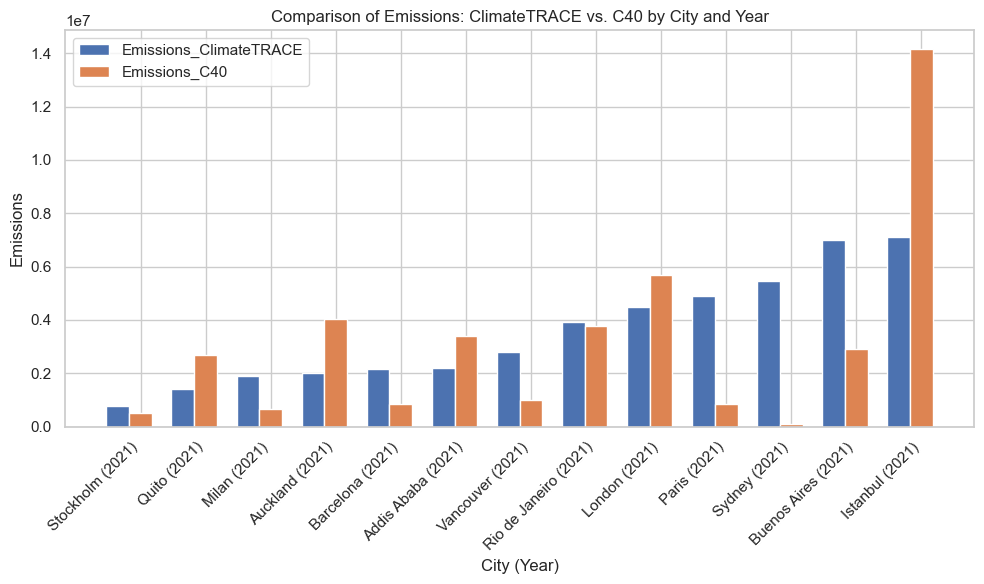

In [8]:
# Bar chart
plt.figure(figsize=(10, 6))

bar_data = df_int.set_index(['city', 'year'])
bar_width = 0.35
index = range(len(bar_data))

plt.bar(index, bar_data['emissions_ct'], bar_width, label='Emissions_ClimateTRACE')
plt.bar([i + bar_width for i in index], bar_data['emissions_c40'], bar_width, label='Emissions_C40')
plt.xlabel('City (Year)')
plt.ylabel('Emissions')
plt.title('Comparison of Emissions: ClimateTRACE vs. C40 by City and Year')
plt.xticks([r + bar_width for r in range(len(bar_data))], [f"{city} ({year})" for city, year in bar_data.index], rotation=45, ha="right")
plt.legend()

plt.tight_layout()
plt.show()

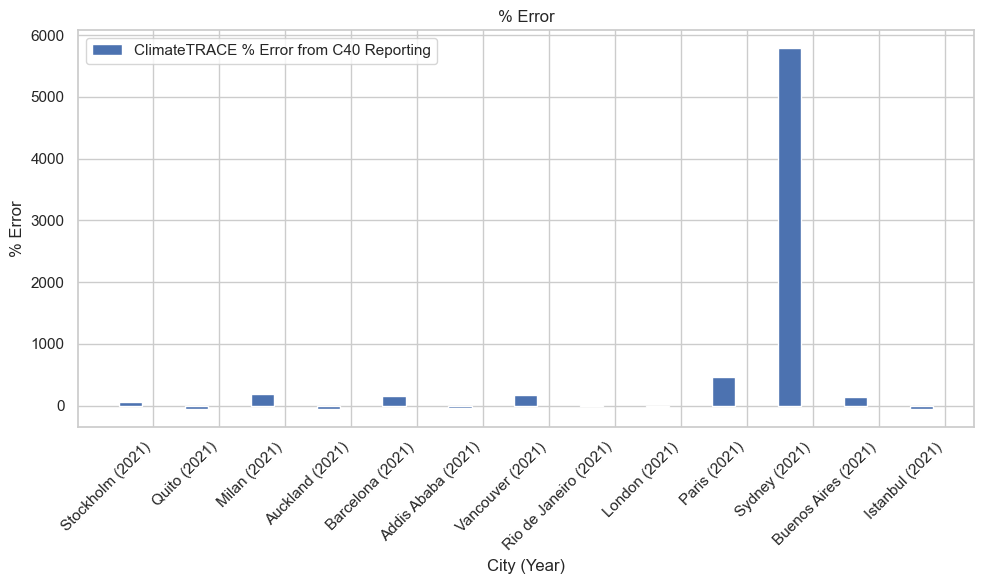

In [9]:
# Bar chart
plt.figure(figsize=(10, 6))

bar_data = df_int.set_index(['city', 'year'])
bar_width = 0.35
index = range(len(bar_data))

plt.bar(index, bar_data['percent_error'], bar_width, label='ClimateTRACE % Error from C40 Reporting')
plt.xlabel('City (Year)')
plt.ylabel('% Error')
plt.title('% Error')
plt.xticks([r + bar_width for r in range(len(bar_data))], [f"{city} ({year})" for city, year in bar_data.index], rotation=45, ha="right")
plt.legend()

plt.tight_layout()
plt.show()